In [1]:
from asyncio.windows_events import NULL
import numpy as np
from collections import Counter
from datetime import datetime as dt
import pickle
import bz2

In [2]:
with open('/Users/mmaze/Desktop/vball_game_data.pbz2', 'rb') as file:
    uncompressed = bz2.BZ2File(file)
    vball = pickle.load(uncompressed)

#Sort by date (Final Array)
vball.sort(order='datetime')

#Equivalent output in a structured array
vball['tournament_name'][1]
vball[1]['tournament_name']

#Calling multiple fields
vball[['tournament_name','type']][1]

("25th Annual AAU Girls' Junior National Beach Volleyball Championships", 'National')

In [3]:

# ELO
# https://www.geeksforgeeks.org/elo-rating-algorithm/
import math
from math import log

def KFactor(games_played, k_0_games, k_inf_games, intertia): 
    k_inf_games = k_inf_games - k_0_games
    if k_inf_games <= k_0_games:
        return k_0_games
    else:
        return k_0_games + k_inf_games/(games_played**(1/intertia))

def Probability(rating1, rating2):
    return 1.0 / (1 + (10 ** ((rating2 - rating1) / 400)))

def EloRating(Ra, Rb, K, won):
    # Probability of Player A
    Pa = Probability(Ra, Rb)
    # Case When Player A wins
    if (won) :
        Ra = Ra + K * (1 - Pa)
    # Case When Player A loses
    else :
        Ra = Ra + K * (0 - Pa)
    return(round(Ra, 4))

def LogLoss(outcome, prob):
    if outcome == True:
        result = 1
    else:
        result = 0
    return -1 * ((result * log(prob)) + ((1 - result) * log(1-prob)))


In [83]:
Probability(1400, 1700)

0.15097955721132328

In [82]:
Probability(1700, 1400)

0.8490204427886767

In [5]:
# example:
print(KFactor(100, 10, 500, 25))
print(EloRating(1100, 1000, 500, False))
print(LogLoss(False, .24))

417.5642478403088
779.9675
0.2744368457017603


In [6]:

def Simulator(k_0_games, k_inf_games, intertia):
    # elo_db:
    # a dictionary with player id as the key
    # the value is a list of [elo, games_played]
    elo_db = dict()
    # (in)corr_sample_dict:
    # key is list of [games_played, opp_game_played]
    # the value is simply a counter for its respective dictionary
    correct_sample_dict = dict()
    incorr_sample_dict = dict()
    # prob_v_res:
    # This list will be filled with a lists representing each row
    # The first item in this sub list represents a win (1) or loss (0)
    # The following two items hold the Elos
    loop = 0
    test_loop=0
    prob_v_res = []
    max_games_played = 0
    max_opp_game_played = 0
    total_log_loss = 0
    loss_counter = 0

    for index, match in enumerate(vball):
        loop+=1
        # add players to database if needed:
        for person in ["player_id", "teammate_id", "opponent1_id", "opponent2_id"]:
            if match[person] not in elo_db.keys():
                elo_db.update({match[person]: [1200, 0]})
        # set parameters     
        avg_oppon = .5 * (elo_db.get(match["opponent1_id"])[0] + elo_db.get(match["opponent2_id"])[0])
        player_elo = elo_db.get(match["player_id"])[0]
        games_played = elo_db.get(match["player_id"])[1] + 1
        opp_game_played = int(.5 * (elo_db.get(match["opponent1_id"])[1] + elo_db.get(match["opponent1_id"])[1]))

        if games_played > max_games_played:
            max_games_played = games_played
        if opp_game_played > max_opp_game_played:
            max_opp_game_played = opp_game_played

        if loop >= 120000:
            test_loop += 1

            # skip over situations where both players are unranked or have same elo
            if player_elo == avg_oppon:
                continue

            # compare preds to actual
            prob = Probability(player_elo, avg_oppon)
            total_log_loss += LogLoss(match["win"], prob)
            loss_counter += 1
            if prob > .5:
                pred_win = True
            else:
                pred_win = False
            if pred_win == match["win"]:
                prob_v_res.append([1, player_elo, avg_oppon])
                if str([games_played, opp_game_played]) not in correct_sample_dict.keys():
                    correct_sample_dict.update({str([games_played, opp_game_played]): 1})
                else:
                    correct_sample_dict.update({str([games_played, opp_game_played]): correct_sample_dict.get(str([games_played, opp_game_played])) + 1})
            else:
                prob_v_res.append([0, player_elo, avg_oppon])
                if str([games_played, opp_game_played]) not in incorr_sample_dict.keys():
                    incorr_sample_dict.update({str([games_played, opp_game_played]): 1})
                else:
                    incorr_sample_dict.update({str([games_played, opp_game_played]): incorr_sample_dict.get(str([games_played, opp_game_played])) + 1})
        k = KFactor(games_played, k_0_games, k_inf_games, intertia)

        # perform calculations/updates
        new_elo = EloRating(player_elo, avg_oppon, k, match["win"])
        elo_db.update({match["player_id"]: [new_elo, games_played]})
    log_loss = total_log_loss/(loss_counter)
    accuracy_dict = {"correct_sample_dict":correct_sample_dict, "incorr_sample_dict":incorr_sample_dict}
    #print(1 - test_loop/loop)
    return (accuracy_dict, max_games_played, max_opp_game_played, elo_db, log_loss, prob_v_res)

In [7]:
def ConditionalAcc(accuracy_dict, min_samp_player, max_samp_player, min_samp_opponent, max_samp_opponent):
    correct = []
    incorr = []
    for i in range(min_samp_player, max_samp_player+1):
        for j in range(min_samp_opponent, max_samp_opponent+1):
            if str([i,j]) in accuracy_dict.get("correct_sample_dict").keys():
                correct.append(accuracy_dict.get("correct_sample_dict").get(str([i,j])))
            if str([i,j]) in accuracy_dict.get("incorr_sample_dict").keys():
                incorr.append(accuracy_dict.get("incorr_sample_dict").get(str([i,j])))
    return round(100 * sum(correct)/(sum(correct) + sum(incorr)),3)

In [8]:
def GridSearch(k_0_list, k_inf_list, intertia_list, loss_metric):
    grid_search = dict()
    for k_0 in k_0_list:
            for k_inf in k_inf_list:
                for intert in intertia_list:
                    output = Simulator(k_0_games = k_0, k_inf_games = k_inf, intertia = intert)
                    accuracy_dict, max_games_played, max_opp_game_played, elo_db, log_loss, prob_v_res = output
                    if loss_metric == "log_loss":
                        loss = log_loss
                    elif loss_metric == "acc":
                        loss = ConditionalAcc(accuracy_dict, 0, max_games_played, 0, max_opp_game_played)
                    grid_search.update({str([k_0, k_inf, intert]): loss})
    if loss_metric == "log_loss":
        return min(grid_search.items(), key=lambda x: x[1]) 
    elif loss_metric == "acc":
        return max(grid_search.items(), key=lambda x: x[1]) 

In [9]:
# Best performance by metric:

#GridSearch([10, 20, 30, 500], [20, 40, 50, 100, 500], [1, 25, 100], "log_loss")
#('[30, 500, 25]', 0.39314373351535953)

#GridSearch([10, 20, 30, 500], [20, 40, 50, 100, 500], [1, 25, 100], "acc")
#('[500, 20, 1]', 84.179)
    # same as a non-adaptive k value 500



In [10]:
output = Simulator(k_0_games = 500, k_inf_games = 100, intertia = 25)
accuracy_dict, max_games_played, max_opp_game_played, elo_db, log_loss, prob_v_res = output
ConditionalAcc(accuracy_dict, 0, max_games_played, 0, max_opp_game_played)
# the more opponent samples we have the better the accuracy 
# the less player samples we have the better the accuracy 

84.179

In [11]:
len(elo_db)

8926

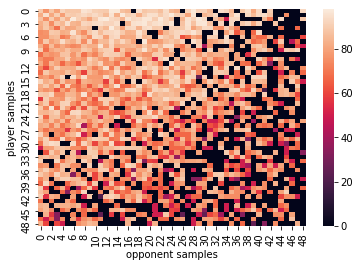

In [12]:
# Compare accuracies across different sample sizes

outer_list=[]
for i in range(1,50):
    inner_list = []
    for j in range(1,50):
        if accuracy_dict.get("correct_sample_dict").get(str([i,j])) == None:
            inner_list.append(NULL)
        elif accuracy_dict.get("incorr_sample_dict").get(str([i,j])) == None:
            inner_list.append(NULL)
        else:
            num_correct = accuracy_dict.get("correct_sample_dict").get(str([i,j]))
            num_incorr = accuracy_dict.get("incorr_sample_dict").get(str([i,j]))
            acc = round(100 * num_correct / (num_correct + num_incorr), 2)
            inner_list.append(acc)
    outer_list.append(inner_list)

import seaborn as sns
import matplotlib.pyplot as plt
ax = sns.heatmap(outer_list)
ax.set_xlabel("opponent samples")
ax.set_ylabel("player samples")
plt.show()

In [13]:
# Compare elo win probabilities against proportion of correct predictions

# key holds a tuple of player and opponent elos
# this loop bins matches based off every 100 elo and tracks how many correct v incorrect predictions
bin_dict = dict()
for row in prob_v_res:
    if row[1] < row[2]:
        bin_floor = row[1]
        bin_ceil = row[2]
    else:
        bin_floor = row[2]
        bin_ceil = row[1] 

    bin_floor = int(bin_floor//100 * 100)
    # if residual for bin_ceil % 100, we need to round up to the nearest 100:
    if bin_ceil % 100 > 0:
        bin_ceil = int((bin_ceil//100 + 1) * 100)
    else:
        bin_ceil = int((bin_ceil//100) * 100)

    if (bin_floor, bin_ceil) not in bin_dict.keys():
        bin_dict.update({(bin_floor, bin_ceil): [0, 0]})
    
    #print(row[0])
    # NEED TO CONFIRM WHY THERE AREN'T REPEAT DIGITS BACK-TO-BACK
    # GAMES ARE REPEATED FROM PLAYER AND OPPONENT PERSPECTIVES SO IT SHOULD REPEAT
    win_loss_counter = bin_dict.get((bin_floor, bin_ceil))
    if row[0] == 1:
        bin_dict.update({(bin_floor, bin_ceil): [win_loss_counter[0] + 1, win_loss_counter[1]]})
    else:
        bin_dict.update({(bin_floor, bin_ceil): [win_loss_counter[0], win_loss_counter[1] + 1]})


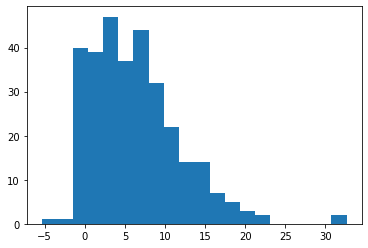

In [14]:

# need to loop through dict and delete values that arent above a certain sample criteria
keys_to_del = []
for key, val in bin_dict.items():
    #print(key)
    #print(sum(val))
    if sum(val) < 20:
        keys_to_del.append(key)
for key in keys_to_del:
    del bin_dict[key]

prob_v_outcome = dict()
for bin, outcome in bin_dict.items():
    expected = round(100 * Probability(bin[1], bin[0]), 2)
    returned = round(100 * outcome[0] / (outcome[0]+outcome[1]), 2)
    dif = round(expected - returned, 2)
    prob_v_outcome.update({bin: [expected, returned, dif]})

dict(sorted(prob_v_outcome.items(), key=lambda item: item[1][2]))

dif = sorted([x[2] for x in prob_v_outcome.values()])
fig, ax = plt.subplots()
ax.hist(dif, bins = 20)
plt.show()

# Updated Visualizations

In [15]:
output = Simulator(k_0_games = 500, k_inf_games = 100, intertia = 25)
accuracy_dict, max_games_played, max_opp_game_played, elo_db, log_loss, prob_v_res = output

In [16]:
prob_list = []
for outcome, play1, play2 in prob_v_res:
    if play1 > play2:
        pred_winner = play1
        pred_loser = play2
    else:
        pred_winner = play2
        pred_loser = play1
    if outcome == 1:
        prob_list.append([outcome, pred_winner, pred_loser])
    else:
        prob_list.append([outcome, pred_loser, pred_winner])
assert(len(prob_v_res) == len(prob_list))

prob_list = [[outcome, pred_winner, pred_loser, Probability(pred_winner, pred_loser)] for outcome, pred_winner, pred_loser in prob_list]
out_array_no_ties=np.array(prob_list)
out_array_no_ties[0:10]

array([[1.00000000e+00, 2.55046850e+03, 2.35780660e+03, 7.51952155e-01],
       [1.00000000e+00, 1.92498740e+03, 9.83472300e+02, 9.95591474e-01],
       [1.00000000e+00, 1.42818330e+03, 9.83472300e+02, 9.28239946e-01],
       [1.00000000e+00, 1.69562750e+03, 7.67162700e+02, 9.95249166e-01],
       [1.00000000e+00, 1.69562750e+03, 1.19978190e+03, 9.45541391e-01],
       [0.00000000e+00, 2.26940240e+03, 2.74498950e+03, 6.07851116e-02],
       [0.00000000e+00, 2.06904510e+03, 2.30924915e+03, 2.00571603e-01],
       [1.00000000e+00, 2.46925950e+03, 2.34311620e+03, 6.73957477e-01],
       [1.00000000e+00, 2.46975970e+03, 2.22773850e+03, 8.01100386e-01],
       [1.00000000e+00, 1.18057760e+03, 7.83393600e+02, 9.07742310e-01]])

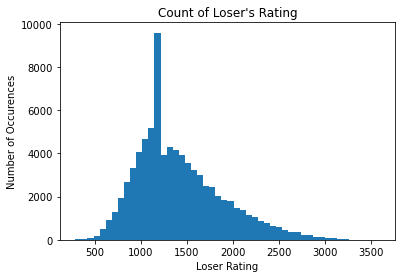

In [17]:
fig, ax = plt.subplots()
ax.hist(out_array_no_ties[:,2], bins = 50)
ax.title.set_text("Count of Loser's Rating")
ax.set_xlabel("Loser Rating")
ax.set_ylabel("Number of Occurences")
plt.show()

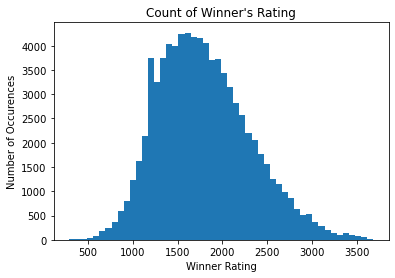

In [18]:
fig, ax = plt.subplots()
ax.hist(out_array_no_ties[:,1], bins = 50)
ax.title.set_text("Count of Winner's Rating")
ax.set_xlabel("Winner Rating")
ax.set_ylabel("Number of Occurences")
plt.show()

In [19]:
bins = np.arange(500, 3500, 100)
bins_lt = [[x, x + 100] for x in bins]
bins_wt=bins_lt.copy()
bins_wt.reverse()

In [20]:
#out_array_no_ties contain: Binary Outcome, WT rating, LT rating, and % chance of winning

game_count_array=np.zeros((len(bins_wt),len(bins_lt)))
exp_win_prob_array=np.zeros((len(bins_wt),len(bins_lt)))
actual_win_prob=np.zeros((len(bins_wt),len(bins_lt)))


#Capture game count in each bin (after training)
for i in out_array_no_ties:
    for ix,x in enumerate(bins_wt):
        for iy,y in enumerate(bins_lt):
            if x[0]<=i[1]<x[1] and y[0]<=i[2]<y[1]:
                game_count_array[ix,iy]+=1

#Capture expected win probability
for i in out_array_no_ties:
    for ix,x in enumerate(bins_wt):
        for iy,y in enumerate(bins_lt):
            if x[0]<=i[1]<x[1] and y[0]<=i[2]<y[1]:
                exp_win_prob_array[ix,iy]+=i[3]/game_count_array[ix,iy]

#Capture actual win probability
for i in out_array_no_ties:
    for ix,x in enumerate(bins_wt):
        for iy,y in enumerate(bins_lt):
            if x[0]<=i[1]<x[1] and y[0]<=i[2]<y[1] and i[0]==1:
                actual_win_prob[ix,iy]+=i[0]/game_count_array[ix,iy]

#Capture residual of actual - expected win probability
residual_win_prob=actual_win_prob-exp_win_prob_array

In [21]:
revised_bins_lt = []
for idx, item in enumerate(bins_lt):
    if idx%2 == 0:
        revised_bins_lt.append(item)
    else:
        revised_bins_lt.append("")
revised_bins_wt = []
for idx, item in enumerate(bins_wt):
    if idx%2 == 0:
        revised_bins_wt.append(item)
    else:
        revised_bins_wt.append("")
    

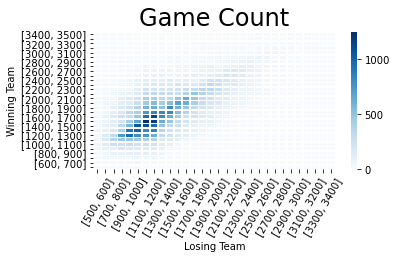

In [22]:
#Plot heatmap of game count
plt.clf()  # For clearing plot
sns.heatmap(
    game_count_array,
    cmap="Blues",
    xticklabels=revised_bins_lt,
    yticklabels=revised_bins_wt,
    linewidth=0.5,
)

plt.xlabel("Losing Team")
plt.ylabel("Winning Team")
plt.rc('font', size=20)  
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16) 
plt.tick_params(axis='x', labelrotation=60)
plt.title("Game Count")
plt.tight_layout()
plt.rcParams['figure.figsize'] = (12, 8)
plt.show()

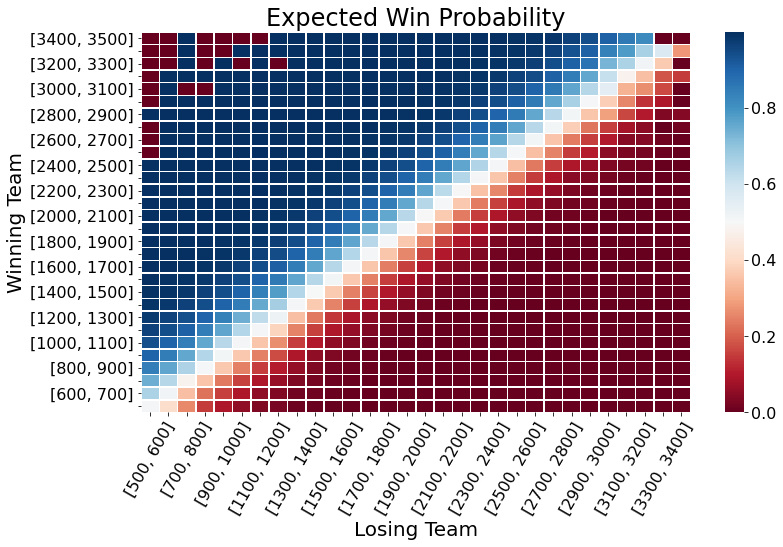

In [23]:
#Plot heatmap of expected win probability
plt.clf()  # For clearing plot
sns.heatmap(
    exp_win_prob_array,
    cmap="RdBu",
    xticklabels=revised_bins_lt,
    yticklabels=revised_bins_wt,
    linewidth=0.5,
)
plt.xlabel("Losing Team")
plt.ylabel("Winning Team")
plt.rc('font', size=20)   
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16) 
plt.tick_params(axis='x', labelrotation=60)
plt.title("Expected Win Probability")
plt.tight_layout()
plt.rcParams['figure.figsize'] = (12, 8)
plt.show()

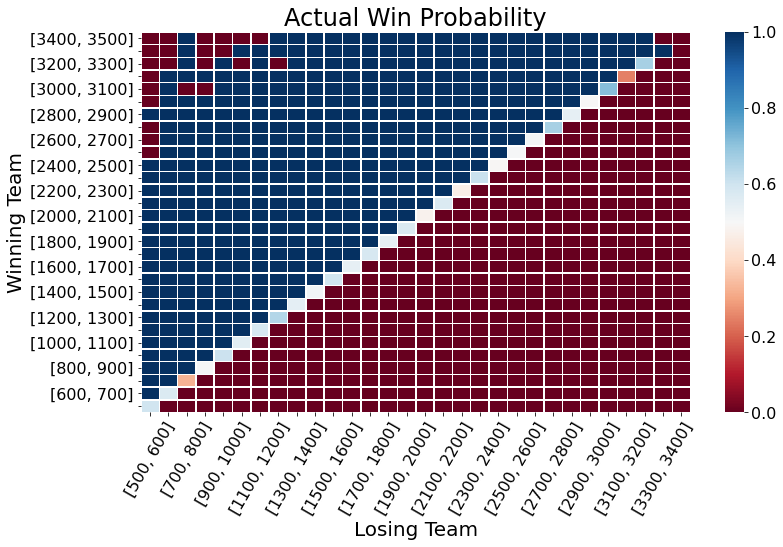

In [24]:
#Plot heatmap of actual win probability
plt.clf()  # For clearing plot
sns.heatmap(
    actual_win_prob,
    cmap="RdBu",
    xticklabels=revised_bins_lt,
    yticklabels=revised_bins_wt,
    linewidth=0.5,
)
plt.xlabel("Losing Team")
plt.ylabel("Winning Team")
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16) 
plt.tick_params(axis='x', labelrotation=60)
plt.title("Actual Win Probability")
plt.tight_layout()
plt.rcParams['figure.figsize'] = (12, 8)
plt.show()

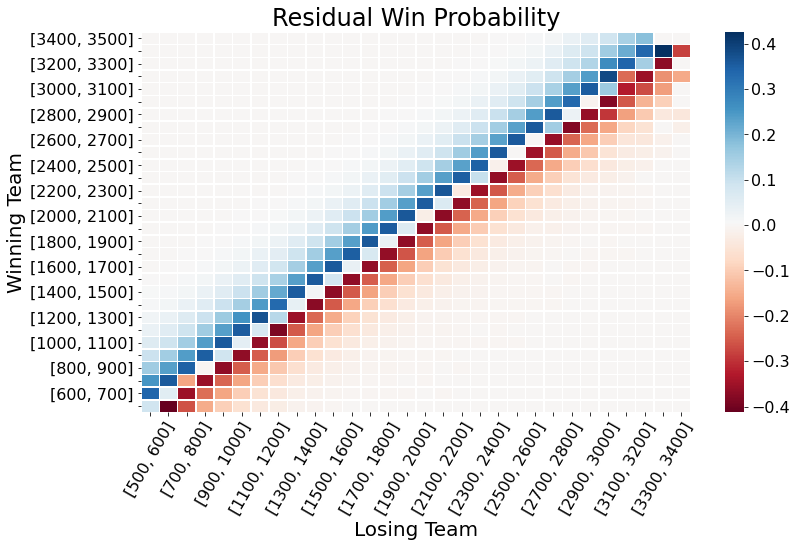

In [25]:

#Plot heatmap of residual win probability
plt.clf()  # For clearing plot
sns.heatmap(
    residual_win_prob,
    cmap="RdBu",
    xticklabels=revised_bins_lt,
    yticklabels=revised_bins_wt,
    linewidth=0.5,
)
plt.xlabel("Losing Team")
plt.ylabel("Winning Team")
plt.rc('font', size=20)   
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16) 
plt.tick_params(axis='x', labelrotation=60)
plt.title("Residual Win Probability")
plt.tight_layout()
plt.rcParams['figure.figsize'] = (12, 8)
plt.show()

# New Data

In [26]:
# max date from original data is feb 27 2022
vball[-1][-1]

numpy.datetime64('2022-02-27T16:00:00.000000')

In [27]:
with open('C:/Users/mmaze/Desktop/Capstone/Pickle_Files/new_vball_game_data.pbz2', 'rb') as file:
    uncompressed = bz2.BZ2File(file)
    vball_new = pickle.load(uncompressed)

#Sort by date (Final Array)
vball_new.sort(order='datetime')
print(len(vball_new))

38668


In [28]:
import datetime as dt

from_date = dt.datetime(2022, 3, 1)
vball_new = [i for i in vball_new if i[-1] > from_date]
print(len(vball_new))

37272


In [29]:
print("new data dates range from", vball_new[0][-1], "to", vball_new[-1][-1])

new data dates range from 2022-03-05T09:00:00.000000 to 2022-06-20T00:30:00.000000


In [30]:

def Simulator_test_set(vball_new, elo_db, k_0_games, k_inf_games, intertia):
    # elo_db:
    # a dictionary with player id as the key
    # the value is a list of [elo, games_played]
    # pulled from train set earlier

    # (in)corr_sample_dict:
    # key is list of [games_played, opp_game_played]
    # the value is simply a counter for its respective dictionary
    correct_sample_dict = dict()
    incorr_sample_dict = dict()
    # prob_v_res:
    # This list will be filled with a lists representing each row
    # The first item in this sub list represents a win (1) or loss (0)
    # The following two items hold the Elos
    loop = 0
    test_loop=0
    prob_v_res = []
    max_games_played = 0
    max_opp_game_played = 0
    total_log_loss = 0
    loss_counter = 0

    for index, match in enumerate(vball_new):
        loop+=1
        # add players to database if needed:
        for person in ["player_id", "teammate_id", "opponent1_id", "opponent2_id"]:
            if match[person] not in elo_db.keys():
                elo_db.update({match[person]: [1200, 0]})
        # set parameters     
        avg_oppon = .5 * (elo_db.get(match["opponent1_id"])[0] + elo_db.get(match["opponent2_id"])[0])
        player_elo = elo_db.get(match["player_id"])[0]
        games_played = elo_db.get(match["player_id"])[1] + 1
        opp_game_played = int(.5 * (elo_db.get(match["opponent1_id"])[1] + elo_db.get(match["opponent1_id"])[1]))

        if games_played > max_games_played:
            max_games_played = games_played
        if opp_game_played > max_opp_game_played:
            max_opp_game_played = opp_game_played

        if loop >= 0:
            test_loop += 1

            # skip over situations where both players are unranked or have same elo
            if player_elo == avg_oppon:
                continue

            # compare preds to actual
            prob = Probability(player_elo, avg_oppon)
            total_log_loss += LogLoss(match["win"], prob)
            loss_counter += 1
            if prob > .5:
                pred_win = True
            else:
                pred_win = False
            if pred_win == match["win"]:
                prob_v_res.append([1, player_elo, avg_oppon])
                if str([games_played, opp_game_played]) not in correct_sample_dict.keys():
                    correct_sample_dict.update({str([games_played, opp_game_played]): 1})
                else:
                    correct_sample_dict.update({str([games_played, opp_game_played]): correct_sample_dict.get(str([games_played, opp_game_played])) + 1})
            else:
                prob_v_res.append([0, player_elo, avg_oppon])
                if str([games_played, opp_game_played]) not in incorr_sample_dict.keys():
                    incorr_sample_dict.update({str([games_played, opp_game_played]): 1})
                else:
                    incorr_sample_dict.update({str([games_played, opp_game_played]): incorr_sample_dict.get(str([games_played, opp_game_played])) + 1})
        k = KFactor(games_played, k_0_games, k_inf_games, intertia)

        # perform calculations/updates
        new_elo = EloRating(player_elo, avg_oppon, k, match["win"])
        elo_db.update({match["player_id"]: [new_elo, games_played]})
    log_loss = total_log_loss/(loss_counter)
    accuracy_dict = {"correct_sample_dict":correct_sample_dict, "incorr_sample_dict":incorr_sample_dict}
    #print(1 - test_loop/loop)
    return (accuracy_dict, max_games_played, max_opp_game_played, elo_db, log_loss, prob_v_res)

In [31]:
output = Simulator_test_set(vball_new, elo_db, k_0_games = 500, k_inf_games = 100, intertia = 25)
accuracy_dict, max_games_played, max_opp_game_played, elo_db_test, log_loss, prob_v_res = output
ConditionalAcc(accuracy_dict, 0, max_games_played, 0, max_opp_game_played)

84.157

In [32]:
len(elo_db_test)

10510

## Summary Stats

In [42]:
vball_all = np.concatenate((vball, np.array(vball_new)), axis=0)

In [80]:
from scipy.stats import pearsonr

# as we filter the data to take only higher sample sizes, the pearson correlation decreases
elo_rt = [x for x, y in elo_db_test.values() if y > 20]
samp_size = [y for x, y in elo_db_test.values() if y > 20]

pearsonr(elo_rt, samp_size)

(0.37373793071857736, 8.173667272004043e-91)

In [66]:
# {id: [rating, games]}
elo_rt = [x for x, y in elo_db_test.values() if y > 10]
samp_size = [y for x, y in elo_db_test.values() if y > 10]

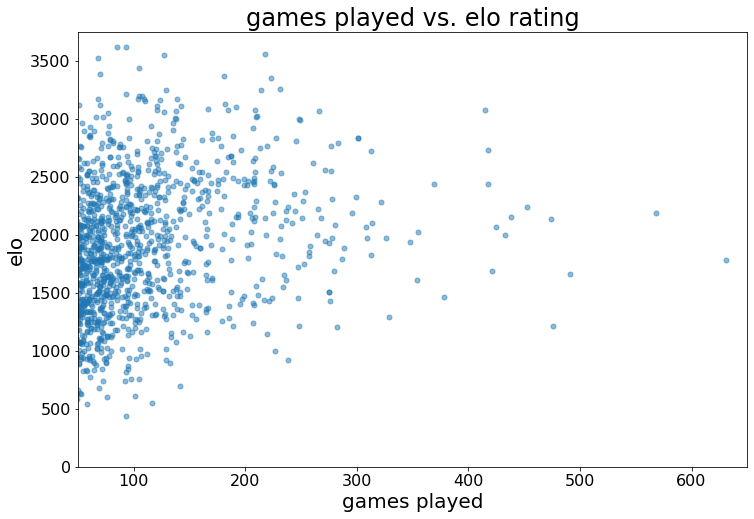

In [81]:
plt.scatter(samp_size, elo_rt, alpha=0.5, s = 25)
plt.title("games played vs. elo rating")
plt.xlabel("games played")
plt.ylabel("elo")
plt.axis([50, 650, 0, 3750])
plt.show()